In [6]:
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
# import numpy.matlib
import matplotlib.pyplot as plt

In [2]:
class Params:
    def __init__(self,
            Lx=np.inf,  
            Ly=np.inf,
            t=1,
            Delta=1,
            m=1,
            bcx=1,
            bcy=-1,
            T=0,    #Temperature
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.t = t
        self.Delta = Delta
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf: # finite size
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(hopx, np.eye(Ly))
            hopymat = np.kron(np.eye(Lx), hopy)
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay))* 1j*t-Delta*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf: # inf size
            self.dxmax=dxmax
            self.dymax=dymax
            self.dx=lambda kx: t*np.sin(kx)
            self.dy=lambda ky: t*np.sin(ky)
            self.dz=lambda kx,ky: m-Delta*np.cos(kx)-Delta*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))

    def correlation_matrix_inf_fft(self,threshold=[1024,512]):
        '''
        self.dxmax/self.dymax: the maximal distance in x/y direction (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.Lx==np.inf and self.Ly==np.inf, "Wire length should be inf"
        Nxmax=max(2*self.dxmax,threshold[0])
        Nymax=max(2*self.dymax,threshold[1])
        if self.T>0:
            pass    #to be filled
        else:
            kxlist=np.arange(0,2*np.pi,2*np.pi/Nxmax)
            kylist=np.arange(0,2*np.pi,2*np.pi/Nymax)
            kxmap,kymap=np.meshgrid(kxlist,kylist)
            dxmap=self.dx(kxmap)
            dymap=self.dy(kymap)
            dzmap=self.dz(kxmap,kymap)
            Ekmap=np.sqrt(dxmap**2+dymap**2+dzmap**2)
            Ekxymap=np.sqrt(dxmap**2+dymap**2)
            costheta=dzmap/Ekmap
            sintheta=Ekxymap/Ekmap
            Ekxymap[0,0]=np.inf #to avoid 0/0=NaN in cos(phi) & sin(phi), because e^{i*phi} sin(theta)=0 when dx,dy=0, so set the denominator to inf to force it to be zero.  the order of this line matters
            cosphi=dxmap/Ekxymap
            sinphi=dymap/Ekxymap
            fftcostheta=np.fft.ifft2(costheta)
            constmap=np.zeros((Nymax,Nxmax))
            constmap[0,0]=0.5
            A_11=constmap-fftcostheta/2
            A_22=constmap+fftcostheta/2
            A_12=np.fft.ifft2(-(cosphi-1j*sinphi)/2*sintheta)
            A_21=np.fft.ifft2(-(cosphi+1j*sinphi)/2*sintheta)
            mat=np.stack([[A_11,A_12],[A_21,A_22]])
            C_f=np.zeros((2*self.dxmax*self.dymax,2*self.dxmax*self.dymax))*1j
            for i in range(self.dxmax*self.dymax):
                for j in range(i):
                    di,dj=(i-j)%self.dymax,(i-j)//self.dymax
                    C_f[2*i:2*i+2,2*j:2*j+2]=mat[:,:,di,dj]
            C_f=C_f+C_f.T.conj()
            for i in range(self.dxmax*self.dymax):
                C_f[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0,0]
            self.C_f=C_f

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>  for finite size
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(
            self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False):
        '''
        convert the [subregion_x,subregion_y] to linear index
        If proj ==True, then the index used for projection operator will be returned
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            linear_index = ((X*self.Ly+Y).flatten('F'))
        else:
            linear_index = ((X*self.dymax+Y).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, 2)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregion_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]



In [4]:
m_list=np.linspace(1,3,20)
LN_no_inf_list=[]
MI_no_inf_list=[]
for m in m_list:
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=8)
    MI_no_inf_list.append(params.mutual_information_m([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))
    LN_no_inf_list.append(params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))

Text(0, 0.5, '[log 2]')

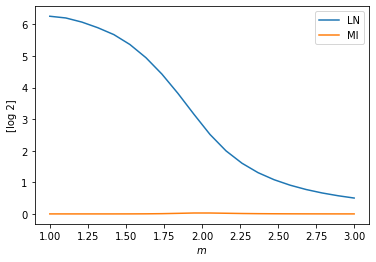

In [8]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_inf_list/np.log(2),label='LN')
ax.plot(m_list,MI_no_inf_list/np.log(2),label='MI')
ax.legend()
ax.set_xlabel(r'$m$')
ax.set_ylabel(r'[log 2]')